In [63]:
import numpy as np
import numpy.ma as ma
import theano
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

theano.config.optimizer="None"

def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

In [64]:
# sequences (if any), prior result(s) (if needed), non-sequences (if any)
import theano.tensor.signal.conv as tt_conv
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # not neede in actual model, but I can't find my but at the moment

d = tt.dvector()
s_median_incubation = tt.dscalar()
s_sigma_incubation = tt.dscalar()

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def theano_convolve_inputrotation(inp,filt,amplitude=1,offset=0):
    """ convolves inp with filter,
        scales by amplitude,
        additional offset in positions
      --> ouput vector has length 2*inp+filt """
    # Symbolic variables for theano
    o = tt.scalar('o',dtype='int64')
    a = tt.matrix('a',dtype='float64')
    b = tt.matrix('b',dtype='float64')
    s = tt.scalar('s',dtype='float64')
    
    # Enlarge the input in order to accomodate an offset
    zero = tt.zeros_like(a)
    a0 = tt.concatenate((a,zero,),1)
    a0r = tt.roll(a0,o,1) # delay the input signal by offset
    a0rp = tt.set_subtensor(a0r[0,:o],0) * s # set front of enlarged input_vector to zero to prevent roll overspill at front
    
    # Convolve enlarged,delayed input with filter
    func = tt.signal.conv.conv2d(a0rp,b,(1,inp.shape[0]*2),(1,filt.shape[0]),border_mode='full')
    # Bild a function
    return theano.function([a,b,s,o],func)(inp[None,:],filt[None,:],amplitude,offset)

def SEIR_model_deaths(N, imported_t,lambda_t,median_incubation,sigma_incubation,l=16):
    N = tt.cast(N,'float64')
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
    print(beta)
    
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    s_infected_t = tt.vector()
    p_infected = tt.dvector("internal state")
    

    def imported_day_acc(lambda_at_t,imported_at_t,p_infected,N_at_t,beta,N):
        f = N_at_t / N
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t * f
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new)
        return new,p_infected,N_at_t-new
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=imported_day_acc,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N])
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    newI,I,N = calc_infected(lambda_t,imported_t)
    
    # To achieve different delays, update either the distribution bd,bh or the offset in theano_convolve
    r = np.arange(32)
    bd = f_beta(r,15,.2)[0] # Generate lognormal delay-functions
    bh = f_beta(r,10,.3)[0]
    # Delay newI through convolution to generate new hospitalization and new deaths
    newH = theano_convolve_inputrotation(newI,bh,.20,2)[0]
    newD = theano_convolve_inputrotation(newI,bd,.10,4)[0]
    
    return newI,newD,newH

[0.00000000e+00 5.47896475e-03 1.27947319e-01 2.46343726e-01
 2.30385647e-01 1.61389684e-01 9.90731624e-02 5.71094898e-02
 3.19868297e-02 1.77272090e-02 9.82008058e-03 5.46900411e-03
 3.07228919e-03 1.74416399e-03 1.00164065e-03 5.82140254e-04
 3.42435297e-04 2.03852752e-04 1.22782570e-04 7.47996383e-05
 4.60729351e-05 2.86818357e-05 1.80389080e-05 1.14573449e-05
 7.34614858e-06 4.75306733e-06 3.10219690e-06 2.04171481e-06
 1.35458778e-06 9.05666877e-07 6.10026566e-07 4.13832118e-07]


Text(0, 0.5, 'number of cases')

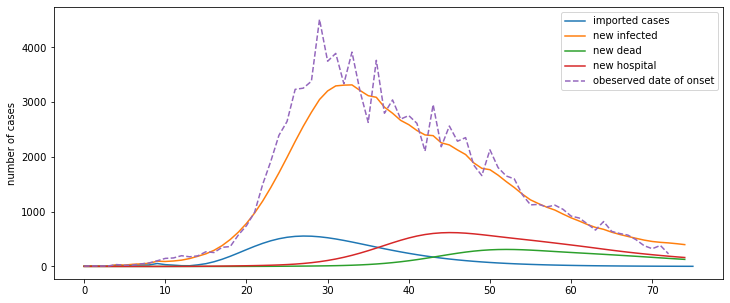

In [65]:
# Test of SEIR Model with deaths and hospitalization
# Epi Curve
epi_curve = [7, 10, 8, 10, 34, 22, 26, 46, 64, 103, 147, 155, 196, 176, 193, 268, 254, 349, 363, 574, 744, 988, 1499, 1921, 2394, 2647, 3233, 3255, 3381, 4511, 3746, 3890, 3336, 3913, 3195, 2630, 3763, 2797, 3040, 2691, 2754, 2613, 2107, 2953, 2185, 2563, 2286, 2352, 1851, 1659, 2129, 1805, 1652, 1598, 1308, 1124, 1133, 1086, 1119, 1043, 919, 884, 778, 664, 820, 640, 601, 572, 488, 378, 324, 383, 230, 168, 112, 20, 6, 2]
epi_curve = np.asarray(epi_curve[:-5]+[-1]*10,dtype=np.float64)
epi_curve = ma.masked_less_equal(epi_curve,0.,copy=True)
# Initial Observations
initial_obs_rki_sit = [9.188,9.188,4.594,4.594,22.971,13.783,27.565,27.565,27.565,53.507,32.821]+[x*.8 for x in [30,17,16,36]+[63.072,106.910,163.956,231.851,306.731,383.947,458.793,527.101,585.620,632.178,665.686,686.005,693.759,690.122,676.616,654.935,626.805,593.878,557.666,519.498,480.503,441.606,403.541,366.868,331.992,299.187,268.619,240.364,214.431,190.776,169.313,149.934,132.509,116.901,102.965,90.561,79.549,69.796,61.177,53.573,46.877,40.989,35.819,31.284,27.311,23.833,20.792,18.134,15.812,13.785,12.017,10.475,9.130,7.958,6.937,6.047,5.272,4.596,4.008,3.496,3.049]]#,2.661,2.322]#,2.027,1.770]
imported_cases = np.asarray(initial_obs_rki_sit[:len(epi_curve)],dtype=np.float64)

# Dummy lambda from model
lambda_t = np.array( [2.045,2.050,2.050,2.054,2.056,2.059,2.064,2.067,2.071,2.076,2.080,2.083,2.082,2.080,2.074,2.071,2.068,2.065,2.060,2.052,2.043,2.033,2.019,1.996,1.953,1.895,1.823,1.731,1.628,1.527,1.406,1.285,1.163,1.070,0.968,0.897,0.867,0.806,0.780,0.755,0.752,0.746,0.752,0.783,0.772,0.793,0.790,0.787,0.754,0.740,0.759,0.748,0.731,0.714,0.685,0.663,0.662,0.667,0.682,0.682,0.680,0.679,0.669,0.665,0.677,0.670,0.672,0.677,0.680,0.683,0.694,0.718,0.750,0.774,0.789,0.793] ,dtype=np.float32)


data = SEIR_model_deaths(86e6,imported_cases,lambda_t,4,.433,l=32)
newI,newD,newH = data

fig, axes = plt.subplots(1, 1, figsize = (12,5),squeeze=False)
ax = axes[0,0]

end = 75
ax.plot(imported_cases,label="imported cases")
ax.plot(newI[:end],label="new infected")
ax.plot(newD[:end],label="new dead")
ax.plot(newH[:end],label="new hospital")
ax.plot(epi_curve,"--",label="obeserved date of onset")
ax.legend()
ax.set_ylabel("number of cases")

In [66]:
print(newI)

[   9.188         9.188         4.69719847    7.1120403    30.09446572
   24.11948179   39.60143084   46.60196369   57.69421891   96.33276582
   90.80623522   99.39805667  115.04036095  144.2990847   185.48078358
  230.44437684  294.08510941  380.80955069  491.4917168   625.43192284
  785.33397436  974.60894423 1194.16887863 1441.67819912 1708.62474449
 1991.35897941 2281.94945398 2559.69065264 2814.36930532 3047.48796036
 3204.06360736 3296.03511681 3309.88660013 3314.52053467 3211.57435818
 3117.61994371 3088.00144994 2908.12857111 2796.82199264 2666.60949843
 2588.24740457 2482.07446173 2401.03178754 2387.78891022 2257.17350069
 2218.08133566 2126.70869872 2043.1303277  1891.22744616 1791.01952859
 1766.20946976 1666.81000021 1549.60662822 1440.41087513 1319.31300293
 1215.0278214  1145.80527791 1081.89876172 1029.31124662  956.08608683
  887.63812555  828.98266801  765.90244165  712.78920275  677.70238064
  625.33828956  583.61533586  547.80215569  513.41053976  480.91562984
  455.

In [73]:
def reportDelayDist(x, mu1, sig1, mu2, sig2, r ):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    r = tt.clip(r,0,1)
    d1 = tt_lognormal(x,mu1,sig1) * r
    d2 = tt_lognormal(x,mu2,sig2) * (1-r)
    ds = d1+d2
    return [ds / (tt.sum(ds,axis=0) + 1e-12)]


def reportDelayDistFunc(x,mu1,sig1,mu2,sig2,r=.5,xs=0):
    d = tt.vector('d',dtype='float64')
    m1 = tt.scalar('m1',dtype='float64')
    s1 = tt.scalar('s1',dtype='float64')
    m2 = tt.scalar('m2',dtype='float64')
    s2 = tt.scalar('s2',dtype='float64')
    sr = tt.scalar('ratio',dtype='float64')
    sof= tt.scalar('offset',dtype='float64')
    
    dm = d + tt.alloc(1,d.shape[0]) * sof
    
    ds = reportDelayDist(dm,tt.log(m1),s1,tt.log(m2),s2,sr)
    return theano.function([d,m1,s1,m2,s2,sr,sof],ds)(x,mu1,sig1,mu2,sig2,r,xs)

def DelayedReporting(cases,mu1,sig1,mu2,sig2,r,n=64):
    x = np.arange(1,n+1,dtype=np.float64)
    dist = reportDelayDistFunc(x,mu1,sig1,mu2,sig2,r)
    
    sc = tt.vector('cases',dtype='float64')
    sb = tt.matrix('filter',dtype='float64')
    mc = tt.nlinalg.alloc_diag(sc)
    mcc = tt.signal.conv.conv2d(mc,sb,border_mode='full')
    ds = tt.sum(mcc,axis=0)
    delayed = theano.function([sc,sb],[ds,mcc])(cases,dist)
    
    #func = tt.signal.conv.conv2d(a0rp,b,(1,inp.shape[0]*2),(1,filt.shape[0]),border_mode='full')
    return delayed

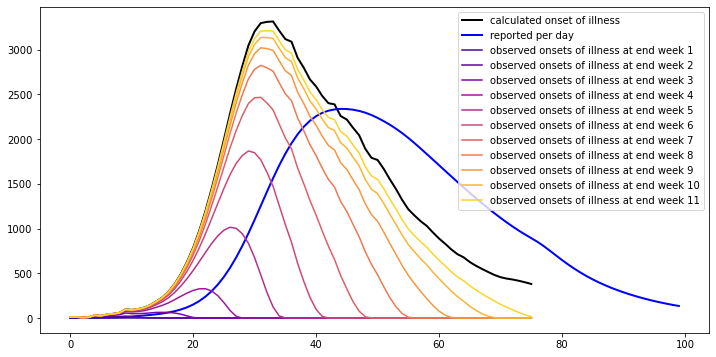

In [74]:
per_day,per_date = DelayedReporting(newI,10,.8,25,.8,.9,64)

fig, axes = plt.subplots(1, 1, figsize = (12,6),squeeze=False)
ax = axes[0,0]

ax.plot(newI,label="calculated onset of illness",color="black",linewidth=2.)
ax.plot(per_day[:100],label="reported per day",color="blue",linewidth=2)
plasma = plt.cm.plasma
for i in range(1,12):
    c = plasma(i/12.)
    ax.plot(np.sum(per_date[:,:i*7],axis=1),color=c,label="observed onsets of illness at end week %d"%i)
ax.legend()

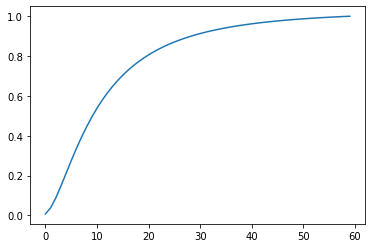

In [72]:
# Assumed reporting delay
d = reportDelayDistFunc(np.arange(60,dtype=np.float64),10.,.8,25.,.8,.9,1)

plt.plot(np.cumsum(d))
plt.plot(d[0]/np.max(d[0]))


Text(0.5, 0.98, 'Evolution of the epicurve from real data')

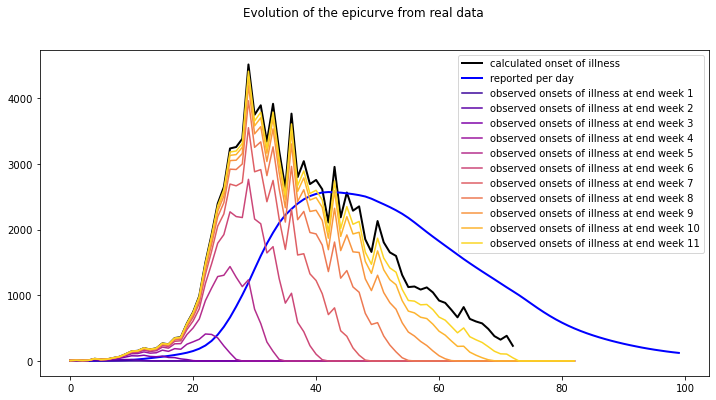

In [82]:
per_day,per_date = DelayedReporting(epi_curve,10,.8,25,.8,.9,64)

fig, axes = plt.subplots(1, 1, figsize = (12,6),squeeze=False)
ax = axes[0,0]

ax.plot(epi_curve,label="calculated onset of illness",color="black",linewidth=2.)
ax.plot(per_day[:100],label="reported per day",color="blue",linewidth=2)
plasma = plt.cm.plasma
for i in range(1,12):
    c = plasma(i/12.)
    ax.plot(np.sum(per_date[:,:i*7],axis=1),color=c,label="observed onsets of illness at end week %d"%i)
ax.legend()
fig.suptitle("Evolution of the epicurve from real data")